#### Install requirements and read in data

In [4]:
# !pip install scikit-video

In [5]:
import os, cv2, scipy.signal, skvideo.io, skvideo.motion, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import sagemaker
from sagemaker.predictor import csv_serializer
from sklearn.preprocessing import Imputer
from IPython.display import clear_output
import time

from sagemaker import get_execution_role
role = get_execution_role()


In [6]:
vid_in_dir = 'mp4Vids/'
out_dir = "sendToAMT" # image sequence frames for labeling
# path_to_json = 'AMTresponses/' # response files

# 0-11 cards, 12-23 chess, 24-35 puzzle, 46-48 jenga
vid_name_list = ["cards_courtyard_T_B", "cards_courtyard_B_T", 
                 "cards_courtyard_H_S", "cards_courtyard_S_H",
                 "cards_livingroom_T_B", "cards_livingroom_B_T",
                 "cards_livingroom_H_S", "cards_livingroom_S_H",
                 "cards_office_T_H", "cards_office_H_T",
                 "cards_office_B_S", "cards_office_S_B",
                 
                 "chess_courtyard_T_B", "chess_courtyard_B_T", 
                 "chess_courtyard_H_S", "chess_courtyard_S_H",
                 "chess_livingroom_T_B", "chess_livingroom_B_T",
                 "chess_livingroom_H_S", "chess_livingroom_S_H",
                 "chess_office_T_B", "chess_office_B_T",
                 "chess_office_H_S", "chess_office_S_H",
                 
                 "puzzle_courtyard_T_H", "puzzle_courtyard_H_T", 
                 "puzzle_courtyard_B_S", "puzzle_courtyard_S_B",
                 "puzzle_livingroom_T_B", "puzzle_livingroom_B_T",
                 "puzzle_livingroom_H_S", "puzzle_livingroom_S_H",
                 "puzzle_office_H_B", "puzzle_office_B_H",
                 "puzzle_office_T_S", "puzzle_office_S_T",
                 
                 "jenga_courtyard_T_S", "jenga_courtyard_S_T", 
                 "jenga_courtyard_H_B", "jenga_courtyard_B_H",
                 "jenga_livingroom_T_B", "jenga_livingroom_B_T",
                 "jenga_livingroom_H_S", "jenga_livingroom_S_H",
                 "jenga_office_T_B", "jenga_office_B_T",
                 "jenga_office_H_S", "jenga_office_S_H",
                 "IMG_3715"]

vid_name = vid_name_list[1] # cards_courtyard_T_B
v1 = skvideo.io.vread(vid_in_dir + vid_name + " copy.mp4")
print("v1 shape: {}".format(v1.shape))
print("vid_name: {}".format(vid_name))

v1 shape: (2700, 720, 1280, 3)
vid_name: cards_courtyard_B_T


In [7]:
def clip_frame(in_frame):
    return in_frame[:2691,:,:,:]

# v1 = np.round(clip_frame(v1)/255.0, 6)
v1 = clip_frame(v1)

print("v1 shape:{}".format(v1.shape))

v1 shape:(2691, 720, 1280, 3)


In [8]:
v1_9 = v1.reshape(299, 9, 720, 1280, 3)

print("v1_9 shape:{}".format(v1_9.shape))

v1_9 shape:(299, 9, 720, 1280, 3)


In [9]:
# worker annotation path
# wa_path = "s3://piml-central/gestures4/cards_courtyard_B_T/gestures4/annotations/worker-response/iteration-1/"
wa_path = vid_name + "_labels_full/"

cols = ['datasetObjectId', 
        'confidence', 
        'jobName',
        'className',
        'humanAnnotated',
        'creationDate',
        'dataType',
        'gestures4']

labeled_df = pd.DataFrame(columns=cols)

json_files = [pos_json for pos_json in os.listdir(wa_path) if pos_json.endswith('.json')]

for l in range(len(json_files)):

    json_files = [pos_json for pos_json in os.listdir(wa_path) if pos_json.endswith('.json')] 
    f = open(wa_path + "/" + json_files[l])
    data = json.load(f)
    f.close()

    for i in range(len(data)):

        datasetObjectId = data[i]['datasetObjectId']
        confidence = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['confidence']
        jobName = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['job-name']
        className = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['class-name']
        humanAnnotated = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['human-annotated']
        creationDate = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['creation-date']
        dataType = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['type']
        gestures4 = data[i]['consolidatedAnnotation']['content']['gestures4']

        df = pd.DataFrame(data=[[datasetObjectId, 
                                 confidence, 
                                 jobName, 
                                 className,
                                 humanAnnotated,
                                 creationDate,
                                 dataType,
                                 gestures4]], columns=cols)

        labeled_df = labeled_df.append(df)


In [10]:
labeled_df.head()

,datasetObjectId,confidence,jobName,className,humanAnnotated,creationDate,dataType,gestures4
0,210,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383172,groundtruth/image-classification,8
0,277,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383192,groundtruth/image-classification,8
0,133,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383206,groundtruth/image-classification,8
0,132,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383217,groundtruth/image-classification,8
0,130,0.70,labeling-job/gestures4,Top Right Hand RELEASE,yes,2019-06-01T10:50:12.383229,groundtruth/image-classification,1


Label: Top Right Hand RELEASE, ObjectId: 130


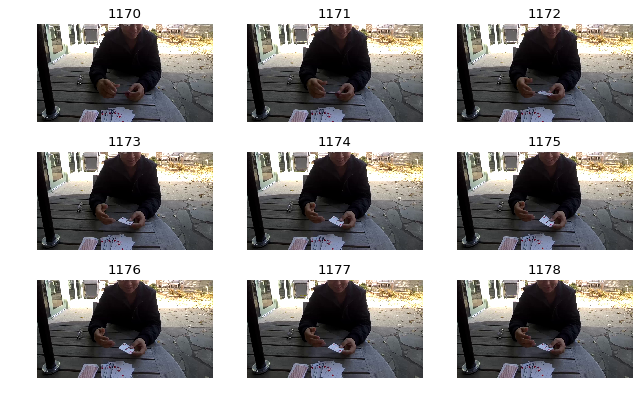

In [11]:
plt.figure(figsize=(8*1.2, 5*1.2), dpi=80, facecolor='w', edgecolor='k')

start_batch = 130
batches = 0

for batch in range(start_batch, start_batch + batches+1): 
    
    n_9batch = batch
    sample_frame = 0
    incr = 1

    clip_name = vid_name + "_" + str(n_9batch) + "_" + str(n_9batch*9) + "_" + str(n_9batch*9 + 8)

    for n in range(1, 10):

        plt.subplot(3, 3, n)
        plt.imshow(v1_9[n_9batch][sample_frame + (n-1)*incr])
        plt.axis('off')
        plt.title(n_9batch*9 + (n-1)*incr)
    
#     clear_output()
        
    label_name = str(labeled_df.loc[labeled_df["datasetObjectId"]==str(batch)]["className"][0])
    print("Label: {}, ObjectId: {}".format(label_name, str(batch)))
    plt.show()
    time.sleep(1)
    

In [75]:
labeled_df["datasetObjectId"] = labeled_df["datasetObjectId"].astype(int)
sorted_df = labeled_df.sort_values(by=["datasetObjectId"])

Y = sorted_df["gestures4"]
# X = v1_9
X = v1 # np.round(v1/255.0, 6)

In [76]:
print("X.shape: {}".format(X.shape))
print("Y.shape: {}".format(Y.shape))

Y = Y.astype(int)

X.shape: (2691, 720, 1280, 3)
Y.shape: (299,)


In [91]:
from skimage.transform import resize

X_resized = np.zeros((X.shape[0], 224, 224, 3))

for i in range(X.shape[0]):
    X_resized[i] = resize(X[i], (224, 224))

Y_resized = np.repeat(Y, 9)

print("X_resized.shape: {}".format(X_resized.shape))
print("Y_resized.shape: {}".format(Y_resized.shape))


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


X_resized.shape: (2691, 224, 224, 3)
Y_resized.shape: (2691,)


In [94]:
num_classes = 10
m = Y_resized.shape[0]
Y_oh = np.zeros((m, num_classes)).astype(int)
Y_oh[np.arange(m), Y_resized] = 1
# Y = Y_oh


In [123]:
num_classes = 10
m = Y.shape[0]
Y_oh_vid = np.zeros((m, num_classes)).astype(int)
Y_oh_vid[np.arange(m), Y] = 1

In [124]:
X_vid_resized = X_resized.reshape(299, 9, 224, 224, 3)

print("X_vid_resized.shape: {}".format(X_vid_resized.shape))
print("Y_oh_vid.shape: {}".format(Y_oh_vid.shape))


X_vid_resized.shape: (299, 9, 224, 224, 3)
Y_oh_vid.shape: (299, 10)


In [126]:
(N, T, H, W, C) = X_vid_resized.shape
CL = 10
tr = 200
va = 35

train_x_5d = X_vid_resized[:tr]
train_y_2d = Y_oh_vid[:tr]
print("train_x_5d shape:", train_x_5d.shape)
print("train_y_2d shape:", train_y_2d.shape)

val_x_5d = X_vid_resized[tr:tr+va]
val_y_2d = Y_oh_vid[tr:tr+va]
print("train_x_5d shape:", val_x_5d.shape)
print("train_y_2d shape:", val_y_2d.shape)

test_x_5d = X_vid_resized[tr+va:]
test_y_2d = Y_oh_vid[tr:tr+va]
print("test_x_5d shape:", test_x_5d.shape)
print("test_y_2d shape:", test_y_2d.shape)


train_x_5d shape: (200, 9, 224, 224, 3)
train_y_2d shape: (200, 10)
train_x_5d shape: (35, 9, 224, 224, 3)
train_y_2d shape: (35, 10)
test_x_5d shape: (64, 9, 224, 224, 3)
test_y_2d shape: (35, 10)


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2, os
import tensorflow as tf
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LeakyReLU, ReLU, Conv2D, MaxPooling2D, Conv3D, Convolution3D, MaxPooling3D, Flatten
from tensorflow.python.keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.logging.set_verbosity(tf.logging.ERROR)

# resnet_weights_path = 'resNet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from keras.utils import multi_gpu_model

In [131]:
model = Sequential()

(N, H, W, T, C) = train_x_5d.shape
input_shape = [H, W, T, C]

print("input shape:{}".format(input_shape))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', input_shape=input_shape, name='3DConv1'))
model.add(LeakyReLU(alpha=.001, name='LeakyRelU1'))
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', input_shape=input_shape, name='3DConv2'))
model.add(LeakyReLU(alpha=.001, name='LeakyRelU2'))

model.add(MaxPooling3D(pool_size=(2,2,2), name='MaxPool3D1'))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', input_shape=input_shape, name='3DConv3'))
model.add(LeakyReLU(alpha=.001, name='LeakyRelU3'))
model.add(Conv3D(256, kernel_size=(3,3,3), padding='same', input_shape=input_shape, name='3DConv4'))
model.add(LeakyReLU(alpha=.001, name='LeakyRelU4'))

model.add(MaxPooling3D(pool_size=(2,2,2), name='MaxPool3D2'))

model.add(Conv3D(512, kernel_size=(3,3,3), padding='same', input_shape=input_shape, name='3DConv5'))
model.add(LeakyReLU(alpha=.001, name='LeakyRelU5'))
# model.add(Conv3D(1024, kernel_size=(3,3,3), padding='same', input_shape=input_shape, name='3DConv6'))
# model.add(LeakyReLU(alpha=.001, name='LeakyRelU6'))

model.add(MaxPooling3D(pool_size=(2,2,2), name='MaxPool3D3'))

model.add(Flatten(name='Flat1'))
model.add(Dense(10, activation='softmax', name='FC1'))

model.summary() 

opt = optimizers.RMSprop(lr=0.005, rho=0.91, epsilon=10-6, decay=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ["accuracy"])


input shape:[9, 224, 224, 3]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3DConv1 (Conv3D)             (None, 9, 224, 224, 64)   5248      
_________________________________________________________________
LeakyRelU1 (LeakyReLU)       (None, 9, 224, 224, 64)   0         
_________________________________________________________________
3DConv2 (Conv3D)             (None, 9, 224, 224, 64)   110656    
_________________________________________________________________
LeakyRelU2 (LeakyReLU)       (None, 9, 224, 224, 64)   0         
_________________________________________________________________
MaxPool3D1 (MaxPooling3D)    (None, 4, 112, 112, 64)   0         
_________________________________________________________________
3DConv3 (Conv3D)             (None, 4, 112, 112, 128)  221312    
_________________________________________________________________
LeakyRelU3 (LeakyReLU)       (None, 4, 112, 112

In [134]:
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

fit_history = model.fit(x = train_x_5d, 
                        y = train_y_2d, 
                        validation_data = (val_x_5d, val_y_2d),
                        epochs = 2, 
                        batch_size = 10)

# parallel_model = multi_gpu_model(model, gpus=8)
# parallel_model.compile((optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

# fit_history = parallel_model.fit(x = train_x_5d, 
#                         y = train_y_2d, 
#                         validation_data = (val_x_5d, val_y_2d),
#                         epochs = 20, 
#                         batch_size = 10)


Train on 200 samples, validate on 35 samples
Epoch 1/2
200/200 [==============================] - 26s 132ms/sample - loss: 0.9782 - acc: 0.9350 - val_loss: 1.5572 - val_acc: 0.9029
Epoch 2/2
200/200 [==============================] - 18s 91ms/sample - loss: 1.0420 - acc: 0.9350 - val_loss: 1.5572 - val_acc: 0.9029


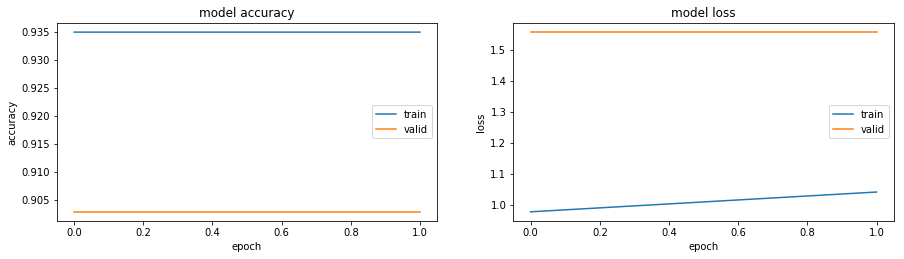

In [135]:
# print(fit_history.history.keys())
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [138]:
model.save("working/bestcnn3D.hdf5")
model.load_weights("working/bestcnn3D.hdf5")

In [139]:
score, acc = model.evaluate(test_x_5d, test_y_2d, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

ValueError: Input arrays should have the same number of samples as target arrays. Found 64 input samples and 35 target samples.